In [8]:
import numpy as np
import pandas as pd


data = pd.read_csv("../data/wdbc.data", sep=",", header=None)

In [9]:
# denote features and improve readability
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave pts", 
            "symmetry", "frac. dim"]
features3 = []
descr = ["mean", "stderr", "worst"]
for i in range(30):
    if i < 10: 
        features3.append(descr[0] + " "+ features[i%10])
    elif i < 20: 
        features3.append(descr[1] + " " + features[i%10])
    else: 
        features3.append(descr[2] + " " + features[i%10])
data.columns = ["ID", "Malignant/Benign"] + features3

data_list = data.values.tolist()
data_y = []
data_x = []
for elem1 in data_list:
    if elem1[1] == 'M':
        data_y.append(1)
    else:
        data_y.append(0)
for elem2 in data_list:
    data_x.append(elem2[2:])

train_data = np.array(data_x[0:469])
train_data_labels = np.array(data_y[0:469])
test_data = np.array(data_x[469:])
test_data_labels = np.array(data_y[469:])

In [34]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)

def kmeans(X, k, max_iters):
    
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    
    converged = False
    
    current_iter = 0
    while (not converged) and (current_iter < max_iters):
        cluster_list = [[] for i in range(len(centroids))]
        
        for x in X:
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)
            
        cluster_list = list((filter(None, cluster_list)))
        
        prev_centroids = centroids.copy()
        
        centroids = []
        
        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))
            
        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))
        
        #print('K-MEANS: ', int(pattern))
        
        converged = (pattern == 0)
        
        current_iter += 1
        
    return np.array(centroids), [np.std(x) for x in cluster_list]

class RBF:
    
    def __init__(self, X, y, tX, ty, num_of_classes, k, std_from_clusters=True):
        self.X = X
        self.y = y
        
        self.tX = tX
        self.ty = ty
        
        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters
        
    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr
    
    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)
    
    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)
    
    def fit(self):
    
        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters = 1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.matmul(np.matmul(np.linalg.pinv(np.matmul(RBF_X.T, RBF_X)), RBF_X.T), self.convert_to_one_hot(self.y, self.number_of_classes))
                
        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)
        
        self.pred_ty = np.matmul(RBF_list_tst, self.w)
        
        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])
        
        diff = self.pred_ty - self.ty
        
        #print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))
        return len(np.where(diff == 0)[0]) / len(diff)
    
    def fit_train(self): 
        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters = 1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.matmul(np.matmul(np.linalg.pinv(np.matmul(RBF_X.T, RBF_X)), RBF_X.T), self.convert_to_one_hot(self.y, self.number_of_classes))
                
        RBF_list_tst = self.rbf_list(self.X, self.centroids, self.std_list)
        
        pred_y = np.matmul(RBF_list_tst, self.w)
        
        pred_y = np.array([np.argmax(x) for x in pred_y])
        
        diff = pred_y - self.y
        
        #print('Train Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))
        return len(np.where(diff == 0)[0]) / len(diff)

In [4]:
RBF_CLASSIFIER = RBF(train_data, train_data_labels, test_data, test_data_labels, num_of_classes = 2, k = 8,
                     std_from_clusters=False)

RBF_CLASSIFIER.fit()

K-MEANS:  1464
K-MEANS:  27
K-MEANS:  297
K-MEANS:  48
K-MEANS:  97
K-MEANS:  25
K-MEANS:  22
K-MEANS:  68
K-MEANS:  7
K-MEANS:  3
K-MEANS:  4
K-MEANS:  9
K-MEANS:  12
K-MEANS:  5
K-MEANS:  12
K-MEANS:  18
K-MEANS:  11
K-MEANS:  9
K-MEANS:  6
K-MEANS:  16
K-MEANS:  14
K-MEANS:  6
K-MEANS:  7
K-MEANS:  29
K-MEANS:  17
K-MEANS:  9
K-MEANS:  21
K-MEANS:  21
K-MEANS:  14
K-MEANS:  19
K-MEANS:  3
K-MEANS:  7
K-MEANS:  0
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0
 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
Accuracy:  0.91


**Optimization** - vary k

In [16]:
train_data = np.array(data_x[0:469])
train_data_labels = np.array(data_y[0:469])
test_data = np.array(data_x[469:])
test_data_labels = np.array(data_y[469:])

train_acc = []
test_acc = []
for kv in range(3, 11): 
    rbfc = RBF(train_data, train_data_labels, test_data, test_data_labels, num_of_classes = 2, k = kv,
                         std_from_clusters=False)
    print("k = ", kv)
    train_acc.append(rbfc.fit_train())
    test_acc.append(rbfc.fit())

k =  3
Train Accuracy:  0.9040511727078892
Accuracy:  0.94
k =  4
Train Accuracy:  0.8869936034115139
Accuracy:  0.88
k =  5
Train Accuracy:  0.9019189765458422
Accuracy:  0.93
k =  6
Train Accuracy:  0.9019189765458422
Accuracy:  0.91
k =  7
Train Accuracy:  0.9040511727078892
Accuracy:  0.91
k =  8
Train Accuracy:  0.8976545842217484
Accuracy:  0.89
k =  9
Train Accuracy:  0.8976545842217484
Accuracy:  0.89
k =  10
Train Accuracy:  0.906183368869936
Accuracy:  0.89


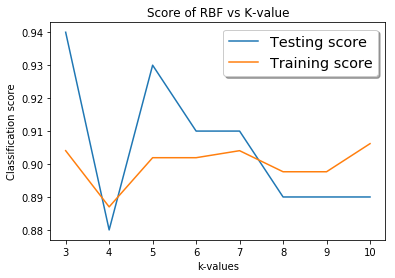

In [17]:
import matplotlib.pyplot as plt

kvals = np.arange(3, 11)
plt.figure()
plt.plot(kvals, test_acc, label='Testing score')
plt.plot(kvals, train_acc, label='Training score')
plt.xlabel('k-values')
plt.ylabel('Classification score')
plt.title('Score of RBF vs K-value')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

**Optimization** - vary training/testing

In [24]:
# vary partitions 50/50, 60/40, 70/30, 80/20, 90/10
entries = len(data_x)
train_acc1 = []
test_acc1 = []
for i in np.arange(0.5, 1.0, 0.1):
    tr_n = int(i *entries)
    trdata = np.array(data_x[0:tr_n])
    trylabels = np.array(data_y[0:tr_n])
    tedata = np.array(data_x[tr_n:])
    teylabels = np.array(data_y[tr_n:])
    rbfc = RBF(trdata, trylabels, tedata, teylabels, num_of_classes = 2, k = 5,
                         std_from_clusters=False)
    print("training on ", i*100, "% of the data")
    train_acc1.append(rbfc.fit_train())
    test_acc1.append(rbfc.fit())

training on  50.0 % of the data
Train Accuracy:  0.8873239436619719
Accuracy:  0.8842105263157894
training on  60.0 % of the data
Train Accuracy:  0.8856304985337243
Accuracy:  0.9078947368421053
training on  70.0 % of the data
Train Accuracy:  0.8944723618090452
Accuracy:  0.9298245614035088
training on  80.0 % of the data
Train Accuracy:  0.9010989010989011
Accuracy:  0.9298245614035088
training on  89.99999999999999 % of the data
Train Accuracy:  0.90234375
Accuracy:  0.9649122807017544


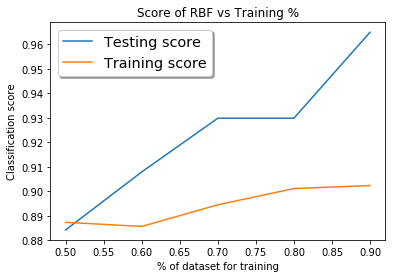

In [25]:
i = np.arange(0.5, 1.0, 0.1)
plt.figure()
plt.plot(i, test_acc1, label='Testing score')
plt.plot(i, train_acc1, label='Training score')
plt.xlabel('% of dataset for training')
plt.ylabel('Classification score')
plt.title('Score of RBF vs Training %')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

In [40]:
from sklearn.model_selection import KFold
X, Y = np.asarray(data_x), np.asarray(data_y)
t1, t2 = [], []
for folds in range(2, 16): 
    traine, teste = 0, 0
    kf = KFold(n_splits=folds)
    print("training on ", folds, " folds")
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        rbfc = RBF(X_train, Y_train, X_test, Y_test, num_of_classes = 2, k = 5,
                         std_from_clusters=False)
        traine += rbfc.fit_train()
        teste += rbfc.fit()
    print("Train: ", traine/folds)
    print("Test: ", teste/folds)
    t1.append(traine/folds)
    t2.append(teste/folds)

training on  2  folds
Train:  0.9121695082777366
Test:  0.8541882876204596
training on  3  folds
Train:  0.9077489237605888
Test:  0.8858442402302051
training on  4  folds
Train:  0.9068715572121252
Test:  0.8929749827637151
training on  5  folds
Train:  0.9094939271255061
Test:  0.8963670237540755
training on  6  folds
Train:  0.908262639721667
Test:  0.9016424038820455
training on  7  folds
Train:  0.909792184622191
Test:  0.9036434808792532
training on  8  folds
Train:  0.9098728919702955
Test:  0.9053697183098591
training on  9  folds
Train:  0.9092770146579876
Test:  0.9071869488536155
training on  10  folds
Train:  0.9088084795321638
Test:  0.9087406015037596
training on  11  folds
Train:  0.9093169886206636
Test:  0.9087823940765118
training on  12  folds
Train:  0.9094156536574963
Test:  0.9091312056737588
training on  13  folds
Train:  0.9093458126157746
Test:  0.9088063099691007
training on  14  folds
Train:  0.9095599186572721
Test:  0.9088414634146341
training on  15  folds

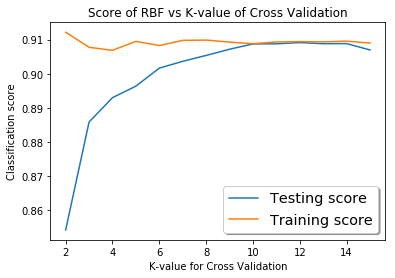

In [41]:
j = np.arange(2, 16)
plt.figure()
plt.plot(j, t2, label='Testing score')
plt.plot(j, t1, label='Training score')
plt.xlabel('K-value for Cross Validation')
plt.ylabel('Classification score')
plt.title('Score of RBF vs K-value of Cross Validation')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()